In [1]:
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification, AdamWeightDecay
import pandas as pd
import numpy as np
import tensorflow as tf
from tqdm import tqdm
import pickle
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from keras.utils import plot_model


2023-02-27 19:14:58.281378: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-27 19:15:00.176876: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda-11.2/lib64:
2023-02-27 19:15:00.177087: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda-11.2/lib64:
2023-02-27 19:15:00.177101: W 

# Read Data

In [2]:
import random
import json


def cirecoDataset(filename, shuffle, sep_token=' '):
    content, labels = [], []
    x = open(filename).readlines()
        
    if shuffle:
        random.shuffle(x)
        
    for line in x:
        instance = json.loads(line)
            
        if len(instance["Correct Answers"]) == 1:
            choices = instance["Choices"]
            context = sep_token.join([instance["Question"], "target: " + instance["Target"], 
                                    "context: " + " <utt> ".join(instance["Dialogue"])])
            l = instance["Correct Answers"][0]

            for k, c in enumerate(choices):
                content.append("{} ; answer: {}".format(context, c))
                if k == l:
                    labels.append(1)
                else:
                    labels.append(0)
                
    return content, labels

In [3]:
df = pd.read_json('./data/cicero/train.json', lines=True)
df

,ID,Dialogue,Target,Question,Choices,Human Written Answer,Correct Answers
0,dream-0004,"[A: : Dad, what will we have for dinner?, B: :...","I don't know. Maybe fried fish, chicken soup a...",What is or could be the cause of target?,[Tom's father is making dinner for everyone to...,[2],[2]
1,dream-0004,"[A: : Dad, what will we have for dinner?, B: :...","I don't know. Maybe fried fish, chicken soup a...",What subsequent event happens or could happen ...,[The speaker expresses he will have fried fish...,[3],[3]
2,dream-0004,"[A: : Dad, what will we have for dinner?, B: :...","I don't know. Maybe fried fish, chicken soup a...",What is or could be the prerequisite of target?,"[It was dinner time for tom and his mom., Tom ...",[4],[4]
3,dream-0004,"[A: : Dad, what will we have for dinner?, B: :...",I'm sorry. But that is the only thing I can co...,What is or could be the motivation of target?,[Tom's father feels helpless because he cannot...,[1],"[1, 3]"
4,dream-0004,"[A: : Dad, what will we have for dinner?, B: :...",I'd like to go to McDonald's this time.,What is or could be the cause of target?,[Tom is bored of eating the same dishes and wa...,[0],[0]
...,...,...,...,...,...,...,...
31413,mutual-0763,"[A: hello , betty !, A: it 's me , tim !, A: a...",i have invited some of my friends to dinner at...,What is or could be the motivation of target?,[The speaker is excited to have lunch with all...,[1],"[1, 3]"
31414,daily-dialogue-2309,"[A: I'm checking out in about half an hour ., ...","Great ! As you know however , the day in New Y...",What is or could be the prerequisite of target?,[The speaker has come to new york for explorin...,[0],[0]
31415,daily-dialogue-2309,"[A: I'm checking out in about half an hour ., ...","Sir , our storage facility is merely $ 5 an ho...",What is or could be the cause of target?,[The listener has to explore new york more but...,[1],[1]
31416,daily-dialogue-2309,"[A: I'm checking out in about half an hour ., ...","Unfortunately , it isn't . VISA or MasterCard ...",What is or could be the prerequisite of target?,[The listener is checking out from the hotel b...,[0],[0]


# train model

In [4]:
train_data, train_label = cirecoDataset('./data/cicero/train.json', True)
test_data, test_label = cirecoDataset('./data/cicero/test.json', False)


### data balancing

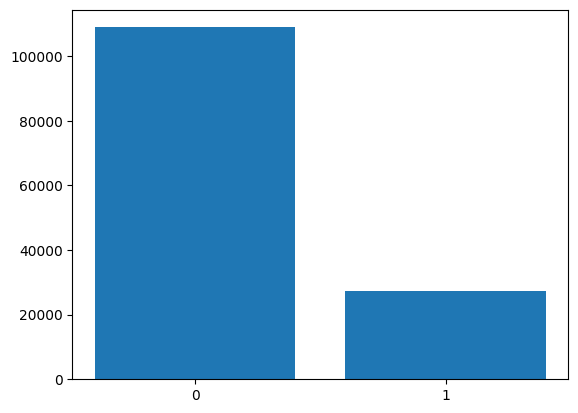

In [5]:
values, counts = np.unique(train_label, return_counts=True)
plt.bar(values, height=counts)
plt.xticks(values, ['0','1']);
plt.savefig('./imbalace_cierco.jpg')

In [6]:
flag = False
new_train_data = list()
new_train_label = list()

for i in range(len(train_label)):
    if train_label[i] == 0 and flag == True:
        new_train_data.append(train_data[i])
        new_train_label.append(train_label[i])
        flag = False
    elif train_label[i] == 1:
        new_train_data.append(train_data[i])
        new_train_label.append(train_label[i])
        flag = True

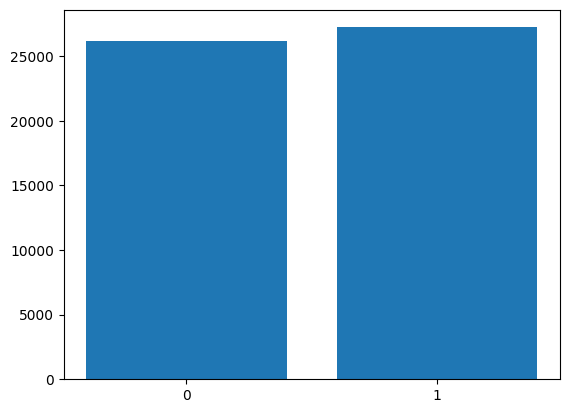

In [7]:
values, counts = np.unique(new_train_label, return_counts=True)
plt.bar(values, height=counts)
plt.xticks(values, ['0','1']);
plt.savefig('./balance_cierco.jpg')

In [8]:
train_data = new_train_data
train_label = new_train_label

In [9]:
def tokenize(df):
    input_ids =  []
    attention_masks =  []
    for i, text in enumerate(df):
        tokens = tokenizer.encode_plus(text, max_length=MAX_LEN,
                                   truncation=True, padding='max_length',
                                   add_special_tokens=True, return_attention_mask=True,
                                   return_token_type_ids=False, return_tensors='tf')          
        input_ids.append(np.asarray(tokens["input_ids"]).reshape(MAX_LEN,))
        attention_masks.append(np.asarray(tokens["attention_mask"]).reshape(MAX_LEN,))
    return (np.asarray(input_ids), np.asarray(attention_masks))


def indices_to_one_hot(data, nb_classes):
    targets = np.array(data).reshape(-1)
    return np.eye(nb_classes)[targets]

In [10]:
MDL_PATH = "microsoft/deberta-base"
MAX_LEN = 40
NUM_EPOCHS = 10
batch_size=8
LR = 1e-5
tokenizer = AutoTokenizer.from_pretrained(MDL_PATH)
deberta = TFAutoModelForSequenceClassification.from_pretrained(MDL_PATH)

2023-02-27 19:15:33.358667: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-27 19:15:33.388654: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-27 19:15:33.389873: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-27 19:15:33.391027: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorF

In [11]:
train_input_ids, train_attention_masks = tokenize(train_data)
y_train = indices_to_one_hot(train_label, 2)


# create model

In [12]:
input_ids = tf.keras.layers.Input(shape=(MAX_LEN,), name='input_ids', dtype='int32')
mask = tf.keras.layers.Input(shape=(MAX_LEN,), name='attention_mask', dtype='int32')

x = deberta(input_ids, attention_mask=mask)[0]

x = tf.keras.layers.Dense(750, activation='relu', name='h1')(x)
x = tf.keras.layers.Dropout(0.1)(x)
x = tf.keras.layers.Dense(150, activation='relu', name='h2')(x)

y = tf.keras.layers.Dense(2, name='outputs')(x)

model = tf.keras.Model(inputs=[input_ids, mask], outputs=y)
model.layers[2].trainable = False
model.summary()


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 40)]         0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 40)]         0           []                               
                                                                                                  
 tf_deberta_for_sequence_classi  TFSequenceClassifie  139193858  ['input_ids[0][0]',              
 fication (TFDebertaForSequence  rOutput(loss=None,               'attention_mask[0][0]']  

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


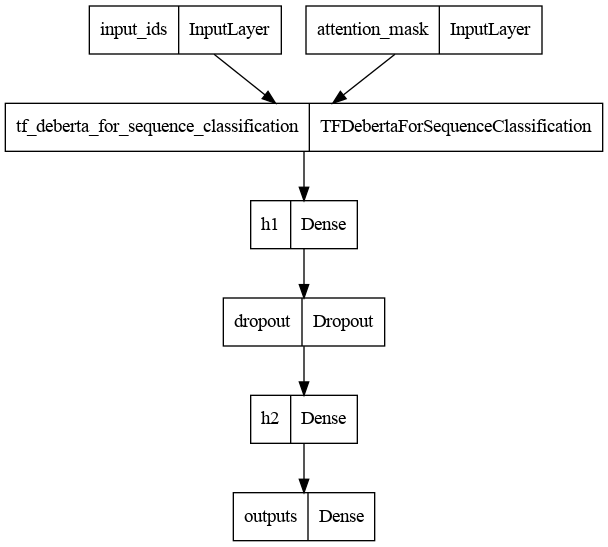

In [13]:
plot_model(model, to_file='./cireco_model.png')

In [14]:
Metrics = [
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='percision'),
    tf.keras.metrics.Recall(name='recall')
]
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=LR), loss = "mse", metrics=Metrics)

In [15]:
history = model.fit((train_input_ids, train_attention_masks), 
                    y_train,
                    batch_size = 100,
                    epochs=5)


Epoch 1/5
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.



KeyboardInterrupt



In [ ]:
# save model
model.save('./model/my_model.h5')

In [16]:
from tensorflow.keras.models import load_model
from keras.utils import CustomObjectScope
import transformers


model = load_model('./model/my_model.h5' , custom_objects={"TFDebertaForSequenceClassification": transformers.TFDebertaForSequenceClassification})

In [18]:
test_input_ids, test_attention_masks = tokenize(test_data)
y_test = indices_to_one_hot(test_label, 2)


In [19]:
test_preds = model.predict((np.asarray(test_input_ids),
                            np.asarray(test_attention_masks)))


1417/1417 [==============================] - 1097s 769ms/step


In [20]:
predictions = list()
for i in test_preds:
    predictions.append(np.argmax(i))
new_y_test = list()
for i in y_test:
    new_y_test.append(np.argmax(i))


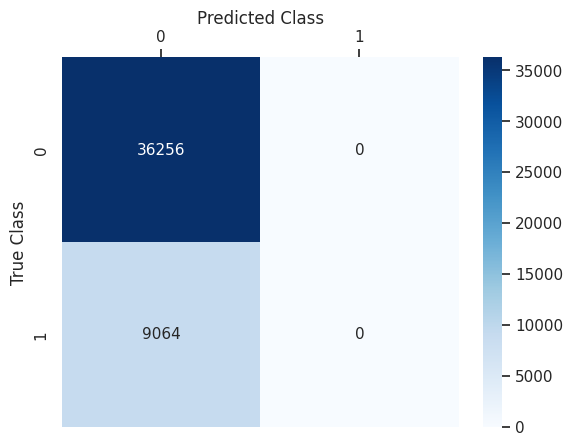

              precision    recall  f1-score   support

           0       0.80      1.00      0.89     36256
           1       0.00      0.00      0.00      9064

    accuracy                           0.80     45320
   macro avg       0.40      0.50      0.44     45320
weighted avg       0.64      0.80      0.71     45320



/home/roshan/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/roshan/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/roshan/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [21]:
confusion = confusion_matrix(new_y_test, predictions)

# plot confusion matrix
sns.set(font_scale=1.0)
labels = [0, 1]
ax = sns.heatmap(confusion, annot=True, annot_kws={"size": 11}, fmt='d', vmin = 0, cmap='Blues', yticklabels=labels, xticklabels=labels)
ax.set_xlabel('Predicted Class')   
ax.set_ylabel('True Class')   
ax.xaxis.set_label_position('top')
ax.xaxis.tick_top()
plt.show()

# print classification report
report = classification_report(new_y_test, predictions, output_dict=False, target_names=["0", "1"],)
print(report)